# Trabalho 2

## Sistema de Tráfego

Neste primeiro exercício pretendemos construir um sistema de tráfego como um grafo orientado ligado, em que os nodos denotam pontos de acesso e os arcos denotam vias de comunicação com um só sentido.

In [66]:
from networkx import nx
import random
from z3 import *

Primeiramente vamos gerar um grafo com 32 nodos aleatoriamente, onde existe um caminho de $n_1 \leadsto n_2$ e um caminho de $n_2 \leadsto n_1$.
A cada origem acrescentamos uma aresta destino, aleatoriamente.

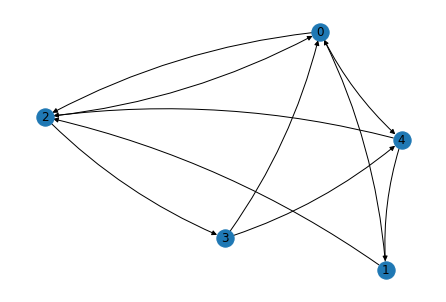

In [103]:
def generate_graph(n):
    graph = nx.DiGraph() 
    
    # gera 32 nodos aleatoriamente
    graph.add_nodes_from([i for i in range(n)]) 
    
    # testa se um grafo está ligado ou não
    connected = nx.is_strongly_connected(graph)
    
    # enquanto o grafo não for ligado, vai continuar a adicionar arestas
    while connected == False: 
        # garantir que todos os nodos têm pelo menos uma ligação a qualquer outro nodo
        for origin in graph.nodes():
            destiny = origin
            while destiny == origin:
                destiny = random.randint(0,n-1)
            graph.add_edge(origin,destiny)
        
        # utilizando a função randint, se calhar 1 ligamos o nodo em que estamos a outro qualquer
        for origin in graph.nodes(): 
            randomize = random.randint(0,1) 
            
            if randomize == 1:
                destiny = random.randint(0,n-1) 
            while destiny == origin:
                destiny = random.randint(0,n-1)
            graph.add_edge(origin,destiny)

        connected = nx.is_strongly_connected(graph)
    
    return graph


graph = generate_graph(5)
nx.draw(graph, with_labels = True, connectionstyle='arc3, rad = 0.1')

### Objetivo
Verificar o maior número de arcos que é possível remover mantendo o grafo ligado.

Trata-se de um problema de optimização, no qual teremos as seguintes restrições.

### Restrições
Dado um grafo aleatoriamente gerado, anteriormente. Seja $V$ o conjunto de vértices e $E$ o conjunto das arestas. Seja o $A$ o conjunto de todos os caminhos.

$d_e = 0$ sse $e$ é cortado

$$\forall_{o \in V} \forall_{t \in V} \cdot \sum{} A_{(o,t)} \cdot d_{(o,t)}$$

#### Objetivo
minimizar o número de arestas que permanecem no grafo para ele continuar ligado $$\sum_{e \in E} d_e$$ e, posteriormente, subtraimos as arestas totais do grafo com o mínimo de arestas que permanecem no grafo para ele continuar ligado. E resulta, no maior número de vias que é possível remover para manter o grafo ligado.

Maior número de vias que é possível remover:  5


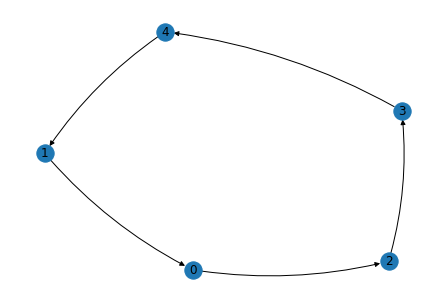

In [104]:
def aux_path(p,edges):
    aux = None
    for i in path_edges(p):
        if(aux != None):
            aux = aux * edges[i]                   
        else: 
            aux = edges[i]
    return aux       

def path_edges(p):
    return [(p[i],p[i+1]) for i in range (len(p)-1)]


def disconnect_paths(graph):
    
    solution = Optimize()
    edges = {}
    
    # inicializar as arestas a 0 e a 1
    for e in graph.edges():
        edges[e]=Int(str(e))
        solution.add(0<=edges[e], edges[e]<=1)
        
    # dado uma origem e destino calcula os caminhos da origem ao destino 
    # posteriormente, utiliza a função aux_path para calcular o valor desses caminhos
    # e, finalmente, a soma desses caminhos tem de ser maior ou igual a 1
    for origin in graph.nodes():
        for destiny in graph.nodes():
            if origin != destiny:
                paths = []
                for p in nx.all_simple_paths(graph,origin,destiny):
                    paths.append(aux_path(p,edges))
                    
                solution.add(Sum(paths)>=1)
    
    #minimizar o número de arestas que permanecem no grafo para ele continuar ligado 
    solution.minimize(Sum(list(edges.values())))

    if solution.check() == sat:
        m = solution.model()
        return [e for e in graph.edges() if m[edges[e]] == 1]
    
result = disconnect_paths(graph)
print("Maior número de vias que é possível remover: ", len(graph.edges()) - len(result))

# remove os edges que estão a mais do grafo
final = graph.copy()
for (o,d) in graph.edges():
    if (o,d) not in result:
        final.remove_edge(o,d)
        
nx.draw(final, with_labels = True, connectionstyle='arc3, rad = 0.1')

## Circuitos Aritméticos

Neste exercício temos como objetivo gerar um um circuito aritmético $N \times 1$ (N inputs e 1 output) com "wires" de 16 bits e "gates" de tipos diferentes.

Começamos por modelar o nosso próprio circuito e tentamos gerar, em $Z_3$, como o circuito funciona.

No entanto, tivemos alguns percalços no que toca a gerar o circuito aritmético aleatoriamente e, no fim, provar se os dados são consistentes entre si e, se forem, determinar inputs que sejam compatíveis com tais outputs.

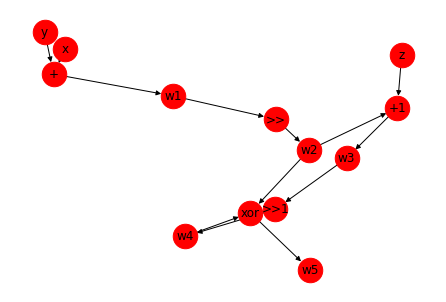

In [86]:
def circuit(n,m,gamma):
    graph = nx.DiGraph()
    graph.add_edge('x','+')
    graph.add_edge('y','+')
    graph.add_edge('+','w1')
    graph.add_edge('w1','>>')
    graph.add_edge('>>','w2')
    graph.add_edge('z','+1')
    graph.add_edge('w2','+1')
    graph.add_edge('+1','w3')
    graph.add_edge('w3','>>1')
    graph.add_edge('>>1','w4')
    graph.add_edge('w2','xor')
    graph.add_edge('w4','xor')
    graph.add_edge('xor','w5')

    return graph
    
graph2 = circuit(3,4,0.5)
nx.draw(graph2, with_labels=True, node_size=600, node_color="red")

In [87]:


# dada uma string de 32 bits ('0' ou '1') devolve o inteiro respectivo
def fromBin(a):
    r = 0
    for i in range(16):
        r = 2*r
        if (a[i]=='1'):
            r = r+1
    return r

# dado um inteiro devolve a string de 32 bits ('0' ou '1') com a sua representação
def toBin(a):
    r = []
    for _ in range(16):
        r.insert(0,'1' if a%2==1 else '0')
        a = a//2
    return ''.join(r)

def soma16_z3(b,c):
    carry = False
    x = []
    for i in range(15,-1,-1):
        soma = Xor(Xor(b[i],c[i]),carry)
        carry = Or((And(b[i],c[i])),And(carry,Or(b[i],c[i])))
        x.insert(0,soma)
    return x

In [100]:
def ar_z3(a,b,n):
    # completar
    c = (a+b)
    return ((c << n) | LShR(c,16-n))

def inv_qr(v):
    x,y,z = BitVecs('x y z',16)
    w2 = ar_z3(x,y,7)
    w4 = ar_z3(z,w2,9)
    w5 = w2 ^ w4
    s = Solver()
    s.add(w2 == BitVecVal(fromBin(v[0:16]),16))
    s.add(w4 == BitVecVal(fromBin(v[16:32]),16))
    #s.add(w5 == BitVecVal(fromBin(v[32:48]),16))
    
    if s.check() == sat:
        m = s.model()
        return toBin(m[x].as_long())+toBin(m[y].as_long())+toBin(m[z].as_long())

texto = '10'*24
final = inv_qr(texto)
print(final)

110101011010101101111111101010101010101010101011
